# **Spit some [tensor] flow**

We need to learn the intricacies of tensorflow to master deep learning

`Let's get this over with`



In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import cv2
print(tf.__version__)

2.2.0


## Look at the following equations 

Well now we're going to go into the details of the implementation; 

```
x_pred_t = w0 + w1 * x_t-1 + w2 * x_t-2 + w3 * x_t-3 + w4 * x_t-4

x_pred_t+1 = w0 + w1 * x_pred_t + w2 * x_t-1 + w3 * x_t-2 + w4 * x_t-3
```

This is an autoregressive model now. 

```
x_pred_5 = w0 + w1 * x_4 + w2 * x_3 + w3 * x_2 + w4 * x_1

x_pred_6 = w0 + w1 * x_pred_5 + w2 * x_4 + w3 * x_3 + w4 * x_2

```

We know that the predictions at time T in an RNN depend on all the previous times. Thus, indirectly, y(t) depends on x(t), x(t-1), x(t-2),....., x(2), x(1)

To optimize the weights, we must take the derivative of the equation containing the weights; however, there will be numerous W_input_to_hidden weights in the network. 


The RNN keeps nesting the older timestamps; the derivatives use multiplication and chain rule in composite functions, thus, the more older the timestamp, the more its gradient vanishes.

## So how do GRU's work?

Throwback to the RNN equation: 

h(t) = activation(W(x,h) x(t) + W(h,h) h(t-1) + b(h))

GRU's calulate two other things to calculate h(t):

- update gate vector z(t)

- reset gate vector r(t)

z(t) = sigmoid(W(x,z) x(t) + W(h,z) h(t-1) + b(z))

r(t) = sigmoid(W(x,r) x(t) + W(h,r) h(t-1) + b(r))

```
h(t) = (1 - z(t)) * h(t-1)  +

        z(t) tanh(W(x,h) x(t) + W(h,h) (r(t) * h(t-1)) + b(h))
```

(*) ==== element wise multiplication

z(t), r(t), h(t) ===== Size U

## Z(t) 

Should we take the new value of h(t)? or keep h(t-1)? 

- z(t) close to 0, take h(t-1)

- z(t) close to 1, take h(t)

So: 

```
h(t) = (1 - z(t)) * h(t-1)  +

        z(t) tanh(W(x,h) x(t) + W(h,h) (r(t) * h(t-1)) + b(h))
```

Becomes 

```
h(t) = (factor keep h(t-1)) * h(t-1) + 

       (discard h(t-1)) * RNN(x(t), h(t-1))
```

## R(t) 

Change the value of h(t-1) 

- r(t) close to 0, zero value h(t-1)

- r(t) close to 1, keep value h(t-1)


## So how do LSTM's work?

### https://towardsdatascience.com/

We add another state to the mix, the cell state c(t)

we add three different neurons:

forget neuron = f(t) 

This gate decides which information should be thrown away or kept. Input from h(t-1) and x(t) is passed through this gate; and it uses sigmoid to either forget (0) or remember (1) it.


input gate neuron = i(t)

We use this to update the cell state. We pass the h(t-1) and x(t) to the sigmoid function. This will decide which values will be updated in the cell state.

output gate neuron = o(t) 

The output gate decides what the next hidden state h(t) should be. Remember that the hidden state contains information on previous inputs. The hidden state is also used for predictions. 

First, we pass the previous hidden state and the current input into a sigmoid function.

Then we pass the newly modified cell state to the tanh function. 

We multiply the tanh output with the sigmoid output to decide what information the hidden state should carry. 

The output is the hidden state. 

The new cell state and the new hidden is then carried over to the next time step.

```

f(t) = sigmoid ( W(x,f) x(t) + W(h, f)h(t-1) + b(f) )

i(t) = sigmoid ( W(x,i) x(t) + W(h, i)h(t-1) + b(i) ) 

o(t) = sigmoid ( W(x,o) x(t) + W(h, o)h(t-1) + b(o) ) 


c(t) = f(t) * c(t-1) + 

       i(t) * tanh ( W(x,c) x(t) + W(h,c) h(t-1) + b(c) ) 


h(t) = o(t) * tanh( c(t) )

```




In [0]:
from tensorflow.keras.layers import Input, Dropout, Dense, Flatten, SimpleRNN, LSTM
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD, Adam, Adamax

## Let's get some synthetic data

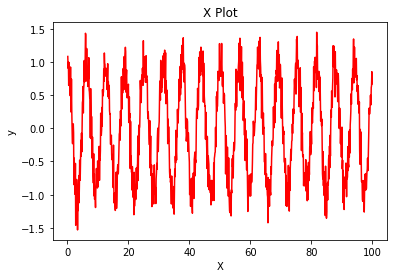

In [0]:
n = 1001
x = 0.1 * np.arange(1,n)
data = np.cos(x) + np.random.randn(n-1) * 0.2

# Visualising the dataset
plt.plot(x, data, color = 'red')
plt.title('X Plot')
plt.xlabel('X')
plt.ylabel('y')
plt.show()


In [0]:
T = 40
D = 1
X = []
y = []
print(len(data))  
print("The last sample would be: " + str(len(data)) + " - " + str(T) + " = " + str((len(data)-T)) )


1000
The last sample would be: 1000 - 40 = 960


In [0]:
for i in range(len(data) - T):
  x = data[i:i+T]
  X.append(x)
  y_temp = data[i+T]
  y.append(y_temp)

In [0]:
# Since we need an N x T x D input
X = np.array(X).reshape(-1, T, D) 
y = np.array(y)

In [0]:
print(X.shape)
print(y.shape)

N, T, D = X.shape

(960, 40, 1)
(960,)


In [0]:
i_layer = Input(shape = (T, D))
h_layer = SimpleRNN(10)(i_layer)
o_layer = Dense(1)(h_layer)
model = Model(i_layer, o_layer)
model.compile(loss = 'mse',
              optimizer = Adam(lr = 0.1))

In [0]:
index = -N//2
report = model.fit(X[:index], y[:index], epochs=50, validation_data=(X[index:], y[index:]))

Epoch 1/50
15/15 [==============================] - 0s 27ms/step - loss: 0.3518 - val_loss: 0.1745
Epoch 2/50
15/15 [==============================] - 0s 20ms/step - loss: 0.1414 - val_loss: 0.1139
Epoch 3/50
15/15 [==============================] - 0s 20ms/step - loss: 0.1079 - val_loss: 0.0956
Epoch 4/50
15/15 [==============================] - 0s 20ms/step - loss: 0.0858 - val_loss: 0.0995
Epoch 5/50
15/15 [==============================] - 0s 22ms/step - loss: 0.0931 - val_loss: 0.0780
Epoch 6/50
15/15 [==============================] - 0s 18ms/step - loss: 0.0824 - val_loss: 0.0709
Epoch 7/50
15/15 [==============================] - 0s 20ms/step - loss: 0.0795 - val_loss: 0.0715
Epoch 8/50
15/15 [==============================] - 0s 19ms/step - loss: 0.0751 - val_loss: 0.0878
Epoch 9/50
15/15 [==============================] - 0s 20ms/step - loss: 0.0891 - val_loss: 0.0691
Epoch 10/50
15/15 [==============================] - 0s 19ms/step - loss: 0.0711 - val_loss: 0.0642
Epoch 11/

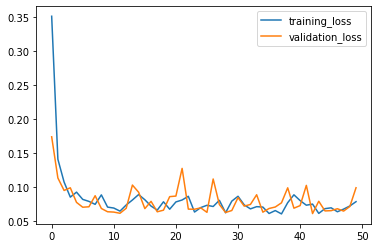

In [0]:
plt.plot(report.history['loss'], label='training_loss')
plt.plot(report.history['val_loss'], label='validation_loss')
plt.legend()

In [0]:
y_test = y[index:]
y_pred = []

In [0]:
X_end = X[index]
while len(y_pred) < len(y_test):
  pred = model.predict(X_end.reshape(1, -1))[0,0]
  y_pred.append(pred)
  X_end = np.roll(X_end, -1)
  X_end[-1] = pred

In [0]:
print(len(y_pred))
print(len(y_test))

480
480


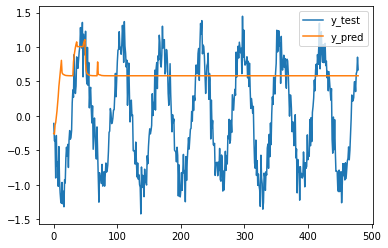

In [0]:
plt.plot(y_test, label='y_test')
plt.plot(y_pred, label='y_pred')
plt.legend()

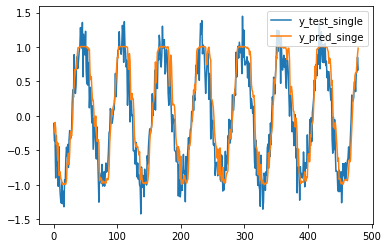

In [0]:
y_test_single = y[index:]
y_pred_single = []

i = index
while len(y_pred_single) < len(y_test_single):
  pred = model.predict(X[i].reshape(1,T, D))[0,0]
  i+=1
  y_pred_single.append(pred)

plt.plot(y_test_single, label='y_test_single')
plt.plot(y_pred_single, label='y_pred_singe')
plt.legend()

## This is bad, the single prediction shows that our model just copies the previous value, this is bad bad bad

But we're in too deep in the world of deep learning, we must find a way! Let's fix our window


1000
The last sample would be: 1000 - 40 = 960
Epoch 1/50
23/23 [==============================] - 0s 19ms/step - loss: 0.2338 - val_loss: 0.0839
Epoch 2/50
23/23 [==============================] - 0s 6ms/step - loss: 0.0779 - val_loss: 0.0699
Epoch 3/50
23/23 [==============================] - 0s 5ms/step - loss: 0.0821 - val_loss: 0.0771
Epoch 4/50
23/23 [==============================] - 0s 5ms/step - loss: 0.0721 - val_loss: 0.0671
Epoch 5/50
23/23 [==============================] - 0s 6ms/step - loss: 0.0639 - val_loss: 0.0631
Epoch 6/50
23/23 [==============================] - 0s 5ms/step - loss: 0.0623 - val_loss: 0.0573
Epoch 7/50
23/23 [==============================] - 0s 5ms/step - loss: 0.0596 - val_loss: 0.0570
Epoch 8/50
23/23 [==============================] - 0s 6ms/step - loss: 0.0637 - val_loss: 0.0624
Epoch 9/50
23/23 [==============================] - 0s 5ms/step - loss: 0.0733 - val_loss: 0.0666
Epoch 10/50
23/23 [==============================] - 0s 6ms/step - los

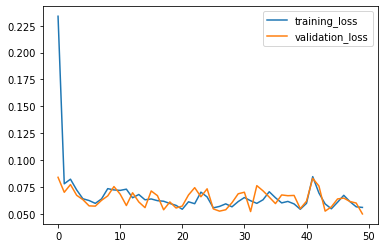

In [0]:
T = 40
D = 1
X = []
y = []
print(len(data))  
print("The last sample would be: " + str(len(data)) + " - " + str(T) + " = " + str((len(data)-T)) )

for i in range(len(data) - T):
  x = data[i:i+T]
  X.append(x)
  y_temp = data[i+T]
  y.append(y_temp)

X = np.array(X).reshape(-1, T, D) 
y = np.array(y)

i_layer = Input(shape = (T, D))
h_layer = LSTM(10, activation='tanh')(i_layer)
o_layer = Dense(1)(h_layer)
model = Model(i_layer, o_layer)
model.compile(loss = 'mse',
              optimizer = Adam(lr = 0.2))

index = -N//4
report = model.fit(X[:index], y[:index], epochs=50, validation_data=(X[index:], y[index:]))

plt.plot(report.history['loss'], label='training_loss')
plt.plot(report.history['val_loss'], label='validation_loss')
plt.legend()

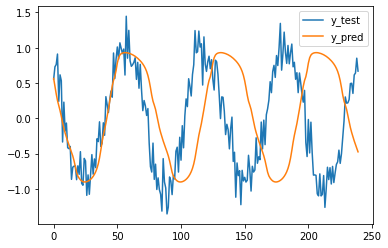

In [0]:
y_test = y[index:]
y_pred = []
X_end = X[index]
while len(y_pred) < len(y_test):
  pred = model.predict(X_end.reshape(1, -1))[0,0]
  y_pred.append(pred)
  X_end = np.roll(X_end, -1)
  X_end[-1] = pred
plt.plot(y_test, label='y_test')
plt.plot(y_pred, label='y_pred')
plt.legend()

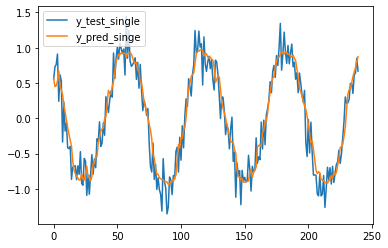

In [0]:
y_test_single = y[index:]
y_pred_single = []

i = index
while len(y_pred_single) < len(y_test_single):
  pred = model.predict(X[i].reshape(1,T, D))[0,0]
  i+=1
  y_pred_single.append(pred)

plt.plot(y_test_single, label='y_test_single')
plt.plot(y_pred_single, label='y_pred_singe')
plt.legend()

1000
The last sample would be: 1000 - 100 = 900
Epoch 1/50
21/21 [==============================] - 0s 21ms/step - loss: 0.1880 - val_loss: 0.0923
Epoch 2/50
21/21 [==============================] - 0s 8ms/step - loss: 0.0809 - val_loss: 0.0742
Epoch 3/50
21/21 [==============================] - 0s 8ms/step - loss: 0.0763 - val_loss: 0.0672
Epoch 4/50
21/21 [==============================] - 0s 8ms/step - loss: 0.0759 - val_loss: 0.0923
Epoch 5/50
21/21 [==============================] - 0s 8ms/step - loss: 0.0822 - val_loss: 0.0671
Epoch 6/50
21/21 [==============================] - 0s 8ms/step - loss: 0.0693 - val_loss: 0.0833
Epoch 7/50
21/21 [==============================] - 0s 8ms/step - loss: 0.0735 - val_loss: 0.0729
Epoch 8/50
21/21 [==============================] - 0s 8ms/step - loss: 0.0662 - val_loss: 0.0565
Epoch 9/50
21/21 [==============================] - 0s 7ms/step - loss: 0.0691 - val_loss: 0.0646
Epoch 10/50
21/21 [==============================] - 0s 7ms/step - lo

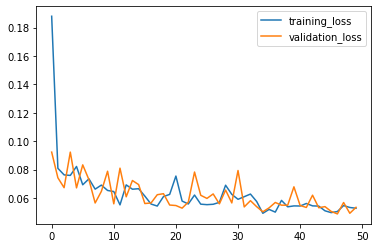

In [0]:
T = 100
D = 1
X = []
y = []
print(len(data))  
print("The last sample would be: " + str(len(data)) + " - " + str(T) + " = " + str((len(data)-T)) )

for i in range(len(data) - T):
  x = data[i:i+T]
  X.append(x)
  y_temp = data[i+T]
  y.append(y_temp)

X = np.array(X).reshape(-1, T, D) 
y = np.array(y)

i_layer = Input(shape = (T, D))
h_layer = LSTM(10, activation='tanh')(i_layer)
o_layer = Dense(1)(h_layer)
model = Model(i_layer, o_layer)
model.compile(loss = 'mse',
              optimizer = Adam(lr = 0.2))

index = -N//4
report = model.fit(X[:index], y[:index], epochs=50, validation_data=(X[index:], y[index:]))

plt.plot(report.history['loss'], label='training_loss')
plt.plot(report.history['val_loss'], label='validation_loss')
plt.legend()

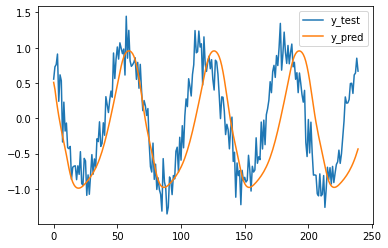

In [0]:
y_test = y[index:]
y_pred = []
X_end = X[index]
while len(y_pred) < len(y_test):
  pred = model.predict(X_end.reshape(1, -1))[0,0]
  y_pred.append(pred)
  X_end = np.roll(X_end, -1)
  X_end[-1] = pred
plt.plot(y_test, label='y_test')
plt.plot(y_pred, label='y_pred')
plt.legend()

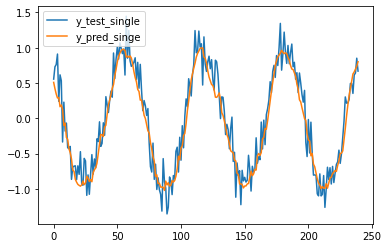

In [0]:
y_test_single = y[index:]
y_pred_single = []

i = index
while len(y_pred_single) < len(y_test_single):
  pred = model.predict(X[i].reshape(1,T, D))[0,0]
  i+=1
  y_pred_single.append(pred)

plt.plot(y_test_single, label='y_test_single')
plt.plot(y_pred_single, label='y_pred_singe')
plt.legend()